Libraries and Dependencies

In [1]:
import MyPipe as mp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error

Function definition

In [2]:
def preprocess_data(raw_data: pd.DataFrame):
    data = raw_data[(raw_data.x * raw_data.y * raw_data.z != 0) & (raw_data.price > 0)] # Clean zero dimensions and negative prices
    data = data.drop(columns=['depth', 'table', 'y', 'z']) # Drop not usefull columns
    data_dummy = pd.get_dummies(data, columns=['cut', 'color', 'clarity'], drop_first=True) # Compute dummies columns
    return data_dummy

def split_data(data: pd.DataFrame, test_size=0.2, random_state=42, apply_ylog = False):
    x = data.drop(columns='price')
    y = data.price
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_size, random_state=random_state)
    if (apply_ylog):
        y_train = np.log(y_train)
        y_test = np.log(y_test)
    return x_train, x_test, y_train, y_test
    
def plot_gof(y_true: pd.Series, y_pred: pd.Series):
    plt.plot(y_true, y_pred, '.')
    plt.plot(y_true, y_true, linewidth=3, c='black')
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.show()

C1.1 Example on how to use the class MyPipe with the whole dataset (no data acquisition)

In [3]:
diamonds = pd.read_csv("https://raw.githubusercontent.com/xtreamsrl/xtream-ai-assignment-engineer/main/datasets/diamonds/diamonds.csv")

data = preprocess_data(diamonds)
x_train, x_test, y_train, y_test = split_data(data, apply_ylog=True)

In [4]:
my_pipeline = mp.MyPipe()
my_pipeline.define_data(data)
my_pipeline.fit(x_train,y_train)

pred = my_pipeline.predict(x_test)
performance = my_pipeline.evaluate_performance(np.exp(y_test), np.exp(pred))

In [5]:
performance

{'r2': np.float64(0.9054), 'MAE': np.float64(561.54)}

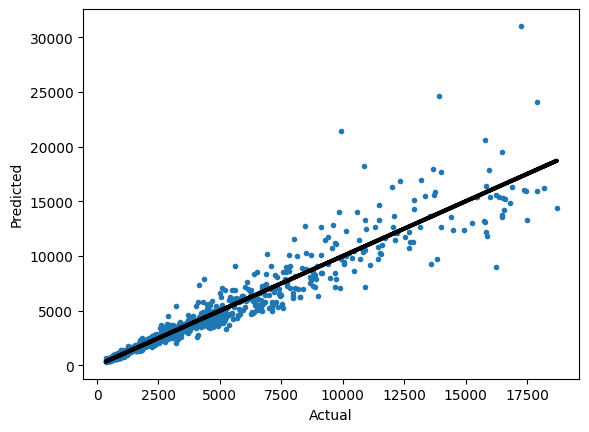

In [6]:
plot_gof(np.exp(y_test), np.exp(pred))

C1.2 Simulate data acquisition

In [7]:
diamonds = pd.read_csv("https://raw.githubusercontent.com/xtreamsrl/xtream-ai-assignment-engineer/main/datasets/diamonds/diamonds.csv")
data = preprocess_data(diamonds)
half = int(len(data.index)/2)
data0 = data[:half] # Suppose we know half of the data at the beginning of the procedure
batch_size = 100 #Number of new diamonds in each batch of new data
data_new = [] # List of the data coming in batch at every update
i = 0
while (half+batch_size*(i+1)<len(data.index)):
    data_new.append(data[half+batch_size*i:half+batch_size*(i+1)])
    i +=1
data_new.append(data[half+batch_size*i:])

# Define the first model with half of the data
x_train, x_test, y_train, y_test = split_data(data0, apply_ylog=True)

my_pipeline = mp.MyPipe()
my_pipeline.define_data(data0)
my_pipeline.fit(x_train,y_train)

pred = my_pipeline.predict(x_test)
performance = my_pipeline.evaluate_performance(np.exp(y_test), np.exp(pred))

for n, current_data in enumerate(data_new):
    print(f'Batch {n+1} of {len(data_new)}')
    my_pipeline.augment_data(current_data)
    x_train, x_test, y_train, y_test = split_data(my_pipeline.data, apply_ylog=True)
    my_pipeline.fit(x_train, y_train)
    pred = my_pipeline.predict(x_test)
    performance = my_pipeline.evaluate_performance(np.exp(y_test), np.exp(pred))



Batch 1 of 25
Batch 2 of 25
Batch 3 of 25
Batch 4 of 25
Batch 5 of 25
Batch 6 of 25
Batch 7 of 25
Batch 8 of 25
Batch 9 of 25
Batch 10 of 25
Batch 11 of 25
Batch 12 of 25
Batch 13 of 25
Batch 14 of 25
Batch 15 of 25
Batch 16 of 25
Batch 17 of 25
Batch 18 of 25
Batch 19 of 25
Batch 20 of 25
Batch 21 of 25
Batch 22 of 25
Batch 23 of 25
Batch 24 of 25
Batch 25 of 25


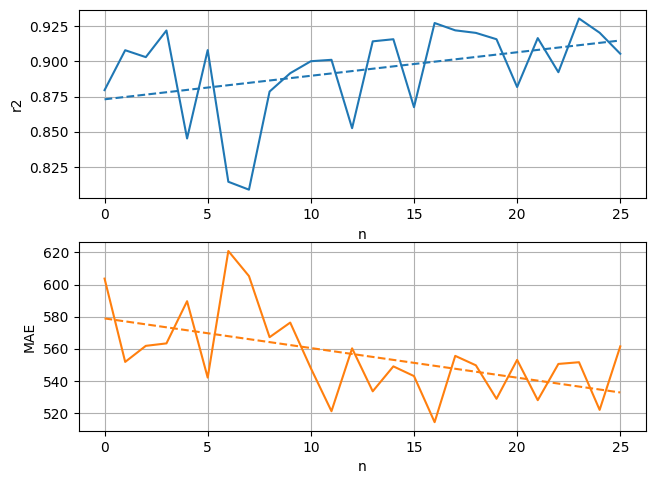

In [8]:
my_pipeline.plot_history(trendline=True)